In [10]:
from utils import DataGenerator
import numpy as np
import pandas as pd 
import librosa

In [2]:
gen = DataGenerator(pd.read_csv('train_set.csv'), 2)

In [11]:
sound_file_paths = ['fma_small/001/001482.mp3', 'fma_small/001/001443.mp3', 'fma_small/001/001197.mp3', 'fma_small/000/000002.mp3', 'fma_small/011/011638.mp3', 'fma_small/011/011672.mp3', 'fma_small/010/010809.mp3', 'fma_small/010/010677.mp3']
                     
sound_names =['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']

def load_sound_files(file_paths):
    raw_sounds = []
    for fp in file_paths:
        X,sr = librosa.load(fp)
        raw_sounds.append(X)
    return raw_sounds

In [12]:
raw_sounds = load_sound_files(sound_file_paths)

In [13]:
len(raw_sounds)

8

In [8]:
def ret_mfcc(raw_sounds):
    mfcc = []
    for i in raw_sounds:
        mfcc.append(librosa.feature.mfcc(y=i, sr=22050))
    return mfcc

In [9]:
spec = ret_mfcc(raw_sounds)
spec[0].shape

(20, 1291)

In [14]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [16]:
print(np.max(spec[1]), np.min(spec[1]))

203.55212229243625 -243.46488570686435


In [15]:
import numpy as np 
import matplotlib.pyplot as plt

In [9]:

%matplotlib inline

for i, class_ in enumerate(spec):
    plt.imshow(class_, origin='lower', aspect='auto')
    plt.title(sound_names[i])
    plt.show()
    

NameError: name 'spec' is not defined

In [13]:
def ret_chroma(raw_sounds):
    chroma = []
    for i in raw_sounds:
        chroma.append(librosa.feature.chroma_stft(y=i, sr=22050))
    return chroma

In [14]:
chroma = ret_chroma(raw_sounds)
chroma[0].shape

(12, 1291)

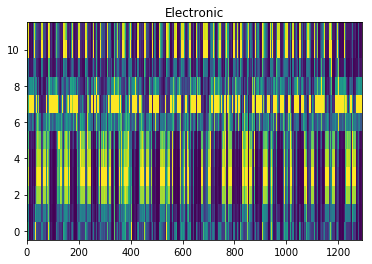

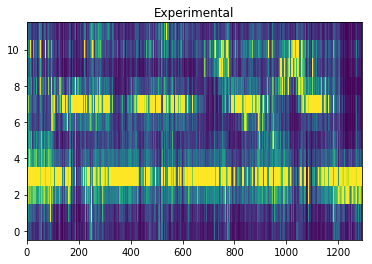

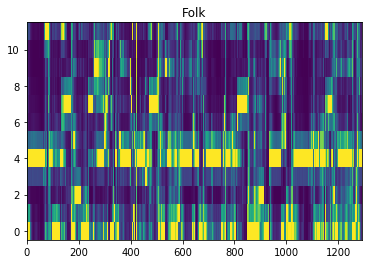

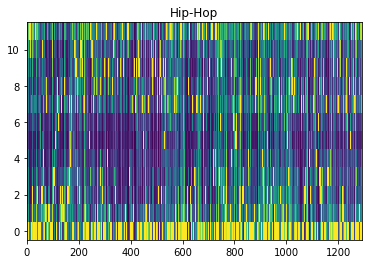

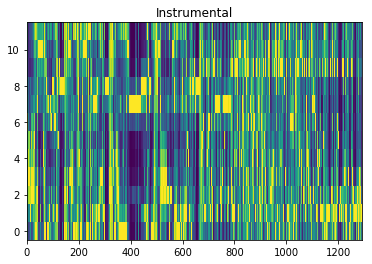

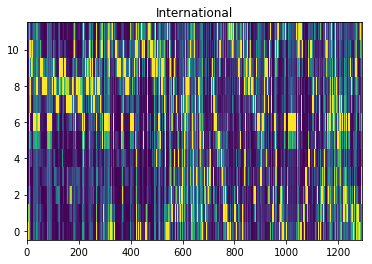

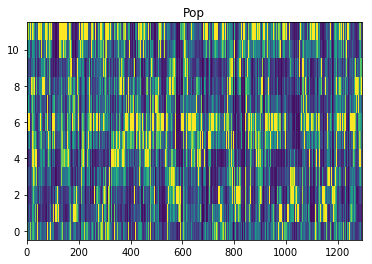

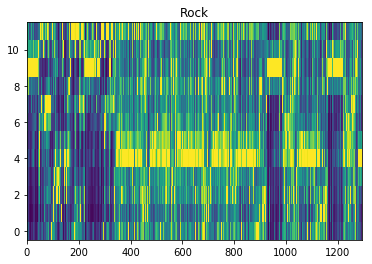

In [15]:
for i, class_ in enumerate(chroma):
    plt.imshow(class_, origin='lower', aspect='auto')
    plt.title(sound_names[i])
    plt.show()
    

In [20]:
def ret_mel(raw_sounds):
    mel = []
    for i in raw_sounds:
        mel.append(librosa.power_to_db(librosa.feature.melspectrogram(y=i, sr=22050)).T)
    return mel

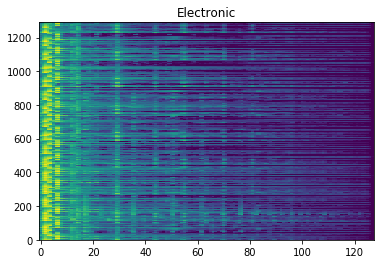

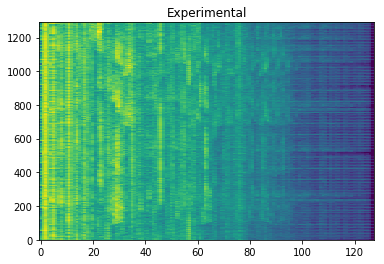

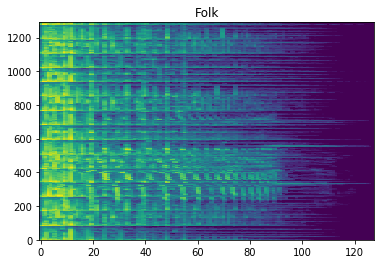

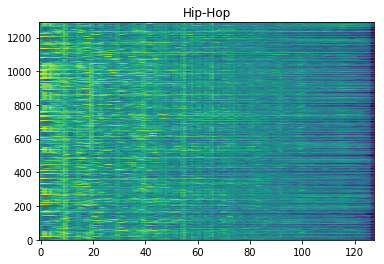

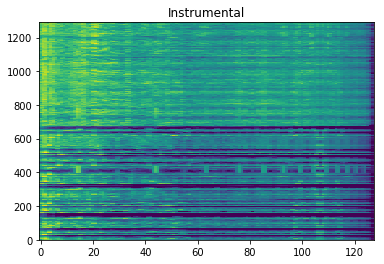

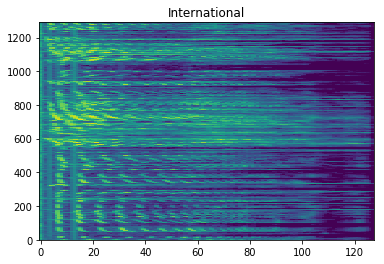

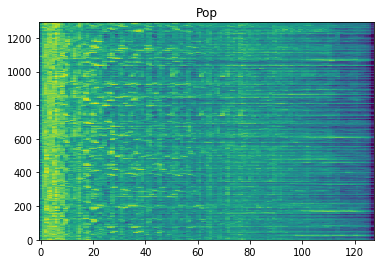

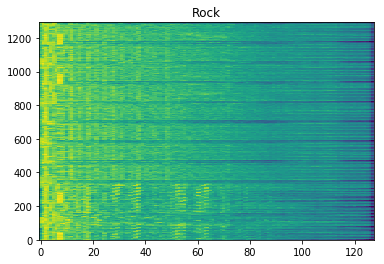

In [21]:
mel = ret_mel(raw_sounds)

for i, class_ in enumerate(mel):
    plt.imshow(class_, origin='lower', aspect='auto')
    plt.title(sound_names[i])
    plt.show()
    

In [18]:
mel[0].shape

(128, 1291)

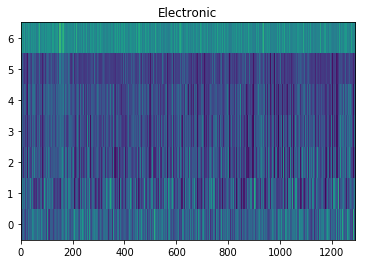

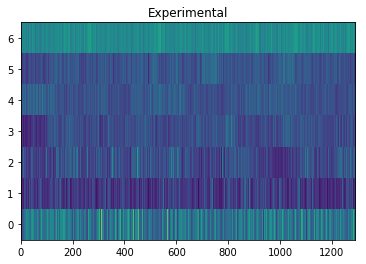

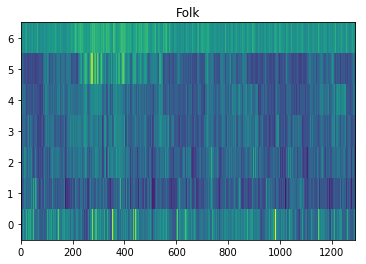

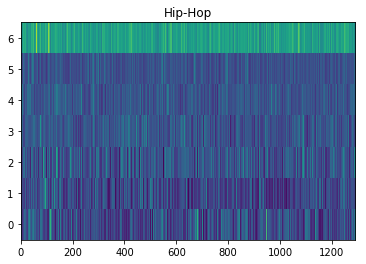

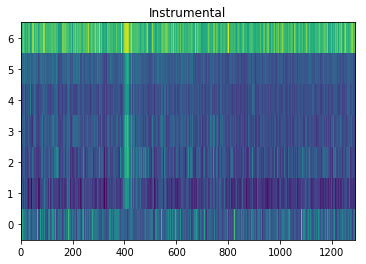

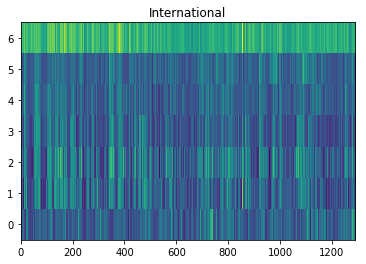

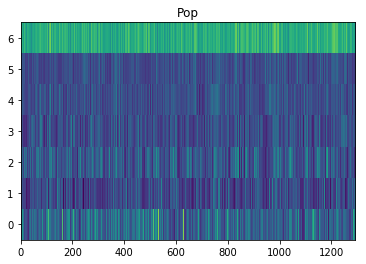

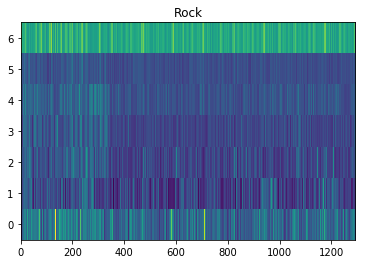

In [19]:
def ret_spec_contrast(raw_sounds):
    spec_contrast = []
    for i in raw_sounds:
        spec_contrast.append(librosa.feature.spectral_contrast(y=i))
    return spec_contrast
spec_contrast = ret_spec_contrast(raw_sounds)


for i, class_ in enumerate(spec_contrast):
    plt.imshow(class_, origin='lower', aspect='auto')
    plt.title(sound_names[i])
    plt.show()

In [21]:
spec_contrast[1].shape

(7, 1291)

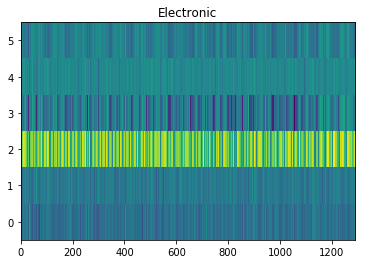

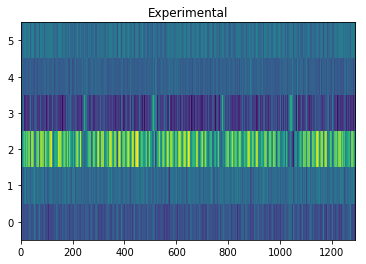

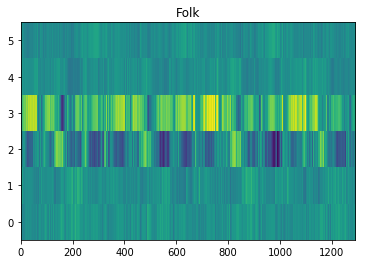

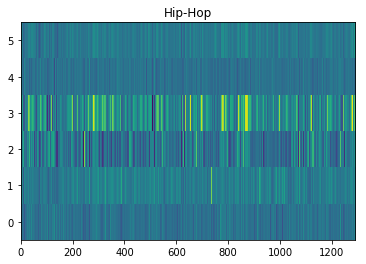

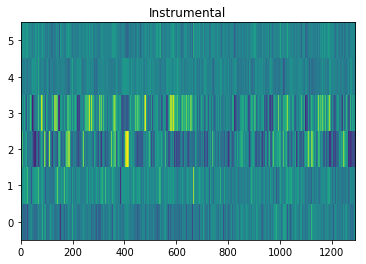

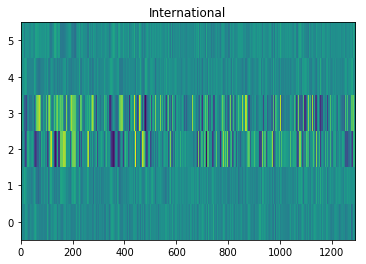

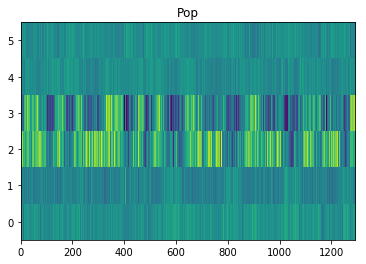

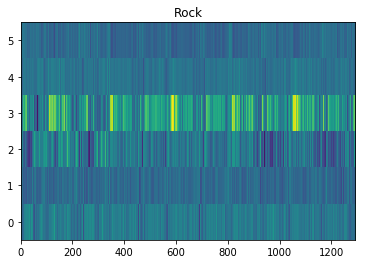

In [22]:
def ret_tonnetz(raw_sounds):
    tonnetz = []
    for i in raw_sounds:
        tonnetz.append(librosa.feature.tonnetz(y=i))
    return tonnetz
tonnetz = ret_tonnetz(raw_sounds)


for i, class_ in enumerate(tonnetz):
    plt.imshow(class_, origin='lower', aspect='auto')
    plt.title(sound_names[i])
    plt.show()

In [23]:
tonnetz[0].shape

(6, 1291)

In [59]:
from keras.applications.mobilenet import MobileNet
from keras.layers import Dense, Activation, Conv2D, LeakyReLU, Dropout, Reshape, Input, LSTM, Concatenate, AveragePooling1D, \
Flatten, UpSampling2D, BatchNormalization
from keras.models import Model

In [74]:
model = MobileNet(include_top=False, pooling='avg', weights=None)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128       
__________

In [90]:
model = MobileNet(include_top=False, pooling='avg')
model.layers.pop(0)
model.layers.pop(0)
model.layers.pop(0)
#model = Model(inputs=model.layers[0], outputs=model.layers[-1])

inp = Input(shape=(None,None,5))
conv = Conv2D(32,1,strides=(2,2))(inp)

model = model(conv)

model.summary()

ValueError: number of input channels does not match corresponding dimension of filter, 32 != 3

In [76]:
mel_input = Input(shape=(1292, 128))
mel = Conv1D(128, 5, activation='elu')(mel_input)
mel = Conv1D(256, 5, activation='elu')(mel)
mel = AveragePooling1D(5)(mel)

mel = Conv1D(256, 3, activation='elu')(mel)
mel = Conv1D(224, 3, activation='elu')(mel)
mel = Reshape((252,224,1))(mel)


chroma_input = Input(shape=(1292, 12))
chroma = Conv1D(128, 5, activation='elu')(chroma_input)
chroma = Conv1D(256, 5, activation='elu')(chroma)
chroma = AveragePooling1D(5)(chroma)

chroma = Conv1D(256, 3, activation='elu')(chroma)
chroma = Conv1D(224, 3, activation='elu')(chroma)
chroma = Reshape((252,224,1))(chroma)


mfcc_input = Input(shape=(1292, 20))
mfcc = Conv1D(128, 5, activation='elu')(mfcc_input)
mfcc = Conv1D(256, 5, activation='elu')(mfcc)
mfcc = AveragePooling1D(5)(mfcc)

mfcc = Conv1D(256, 3, activation='elu')(mfcc)
mfcc = Conv1D(224, 3, activation='elu')(mfcc)
mfcc = Reshape((252,224,1))(mfcc)


spec_contrast_input = Input(shape=(1292, 7))
spec = Conv1D(128, 5, activation='elu')(spec_contrast_input)
spec = Conv1D(256, 5, activation='elu')(spec)
spec = AveragePooling1D(5)(spec)

spec = Conv1D(256, 3, activation='elu')(spec)
spec = Conv1D(224, 3, activation='elu')(spec)
spec = Reshape((252,224,1))(spec)


tonnetz_input = Input(shape=(1292, 6))
tonnetz = Conv1D(128, 5, activation='elu')(tonnetz_input)
tonnetz = Conv1D(256, 5, activation='elu')(tonnetz)
tonnetz = AveragePooling1D(5)(tonnetz)

tonnetz = Conv1D(256, 3, activation='elu')(tonnetz)
tonnetz = Conv1D(224, 3, activation='elu')(tonnetz)
tonnetz = Reshape((252,224,1))(tonnetz)

x = Concatenate(axis=-1)([mel,chroma,mfcc,spec,tonnetz])
x = MobileNet(include_top=False, pooling='avg')(x)

pred = Dense(8, activation='softmax')(x)

model = Model(inputs=[mel_input, chroma_input, mfcc_input, spec_contrast_input, tonnetz_input], outputs=pred)

model.summary()

ValueError: number of input channels does not match corresponding dimension of filter, 5 != 3